In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset
from IPython.display import Image
from torchinfo import summary
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import PIL
import cv2
import os
from skimage import io
import warnings
warnings.filterwarnings('ignore')

In [34]:
device = torch.device('cpu')
print(device)
IMG_SIZE = 64
BATCH_SIZE = 64

cpu


In [3]:
def full_data(path):
    data = torchvision.datasets.ImageFolder(root=path,
                                            transform=T.Compose([T.Resize((IMG_SIZE,IMG_SIZE))
                                                                #,T.CenterCrop(240)
                                                                ,T.ToTensor()
                                                                #,T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                                                ]))
    data_loader = torch.utils.data.DataLoader(data, 
                                            batch_size=BATCH_SIZE,
                                            shuffle=True)
    return data_loader
def get_mean_std(data_loaded,df):
    mean = [0,0,0]
    std = [0,0,0]
    images = next(iter(data_loaded))[0]
    for image in images:
        for i in range(0,len(image)):
            mean[i] += image[i].mean()
            std[i] += image[i].std()
    
    
    total_mean = [int(x)/256 for x in mean]
    total_std = [int(y)/256 for y in std]
    return total_mean, total_std

In [4]:
fpath = "D:\\misc\\Clothing"
cats = ['dress', 'pants', 'shirt', 'shoes', 'shorts']
df = pd.read_csv("D:\\misc\\Clothing\\labeled.csv")
cat_dict = {0:'dress',1:'pants',2:'shirt',3:'shoes',4:'shorts'}

# Compute rough mean and std for images ev
data_loaded = full_data(fpath)
img_mean, img_std = get_mean_std(data_loaded,df)
print(f"Mean: {img_mean}, STD: {img_std}")

Mean: [0.17578125, 0.16796875, 0.16796875], STD: [0.06640625, 0.0703125, 0.0703125]


In [5]:
class FashionDataset(Dataset):
    def __init__(self, csv, rdir, transform = None):
        self.annotations = pd.read_csv(csv)
        self.rdir = rdir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.rdir, self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        return(image, y_label)

In [6]:
def data_loads(train_set,test_set):
    # Transform and image loading
    transform = T.Compose([T.Resize((IMG_SIZE,IMG_SIZE)),
                           T.ToTensor(),
                           T.Normalize(img_mean,
                                     img_std)])
    #train_set = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
    #test_set = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, 
                                            batch_size=BATCH_SIZE,
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle = True)
    return train_loader, test_loader

In [7]:
transform = T.Compose([T.ToPILImage()
                       ,T.Resize((IMG_SIZE,IMG_SIZE))
                       ,T.ToTensor()
                       ,T.Normalize(img_mean,
                                  img_std)
                       ])
dataset = FashionDataset(csv = "D:\\misc\\Clothing\\labeled.csv", rdir= "D:\\misc\\Clothing\\dataset_full", transform = transform )

In [8]:
train_set, test_set = torch.utils.data.random_split(dataset,[8500,2885])
train_loader, test_loader = data_loads(train_set=train_set,test_set=test_set)

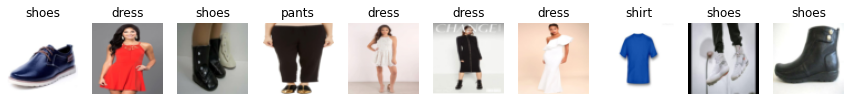

In [9]:
images, labels = next(iter(train_loader))
fig, ax = plt.subplots(1,10)
fig.set_figheight(30)
fig.set_figwidth(15)
for i in range(10):
    x = images[i]* torch.tensor(img_std)[:, None, None] + torch.tensor(img_mean)[:, None, None]
    ax[i].imshow(x.squeeze().permute(1,2,0))
    ax[i].set_title(cat_dict[int(labels[i])])
    ax[i].axis("off")

In [10]:
# Build CNN
class First_CNN(nn.Module):
    def __init__(self,num_classes=5):
        super(First_CNN, self).__init__()
        
        #LeNetish
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16384,64)
        self.fc2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        #print("first conv", x.shape)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        #print("second conv", x.shape)
        x = nn.functional.relu(self.conv3(x))
        #print("third conv", x.shape)
        x = self.flat(x)
        #print("flatten", x.shape)
        x = nn.functional.relu(self.fc1(x))
        #print("relu fc1", x.shape)
        x = self.fc2(x)
        #print("fc2", x.shape)
        return x


In [11]:
net = First_CNN(num_classes=5)
summary(net,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
First_CNN                                --                        --
├─Conv2d: 1-1                            [1, 16, 64, 64]           448
├─MaxPool2d: 1-2                         [1, 16, 32, 32]           --
├─Conv2d: 1-3                            [1, 32, 32, 32]           4,640
├─MaxPool2d: 1-4                         [1, 32, 16, 16]           --
├─Conv2d: 1-5                            [1, 64, 16, 16]           18,496
├─Flatten: 1-6                           [1, 16384]                --
├─Linear: 1-7                            [1, 64]                   1,048,640
├─Linear: 1-8                            [1, 5]                    325
Total params: 1,072,549
Trainable params: 1,072,549
Non-trainable params: 0
Total mult-adds (M): 12.37
Input size (MB): 0.05
Forward/backward pass size (MB): 0.92
Params size (MB): 4.29
Estimated Total Size (MB): 5.26

In [38]:
## Lifted from Microsoft

def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for images,labels in dataloader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        out = net(images)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

#train_epoch(net,train_loader)

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for images,labels in dataloader:
            images, labels = images.cuda(), labels.cuda()
            out = net(images)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

#validate(net,test_loader)

In [13]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

#net = First_CNN()

#hist = train(net,train_loader,test_loader,epochs=5)

In [16]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, train_loader,test_loader, epochs = 10, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.623, Val acc=0.724, Train loss=0.016, Val loss=0.012
Epoch  1, Train acc=0.788, Val acc=0.824, Train loss=0.010, Val loss=0.009
Epoch  2, Train acc=0.835, Val acc=0.861, Train loss=0.008, Val loss=0.007
Epoch  3, Train acc=0.859, Val acc=0.874, Train loss=0.006, Val loss=0.007
Epoch  4, Train acc=0.876, Val acc=0.855, Train loss=0.006, Val loss=0.007
Epoch  5, Train acc=0.892, Val acc=0.879, Train loss=0.005, Val loss=0.006
Epoch  6, Train acc=0.897, Val acc=0.883, Train loss=0.005, Val loss=0.006
Epoch  7, Train acc=0.912, Val acc=0.888, Train loss=0.004, Val loss=0.006
Epoch  8, Train acc=0.920, Val acc=0.892, Train loss=0.004, Val loss=0.005
Epoch  9, Train acc=0.930, Val acc=0.892, Train loss=0.003, Val loss=0.006


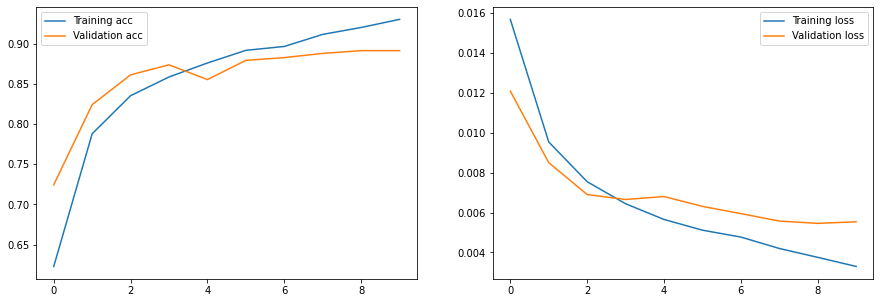

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


In [60]:
# Build CNN
class Second_CNN(nn.Module):
    def __init__(self,num_classes=5):
        super(Second_CNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3, stride=1, padding = 1)
        
        self.pool = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20, kernel_size=3, stride=1, padding = 1)
        
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3, stride=1, padding = 1)
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(32768,64)
        self.fc2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        #print("first conv", x.shape)
        x = nn.functional.relu(self.conv2(x))
        #print("second conv", x.shape)
        x = nn.functional.relu(self.conv3(x))
        #print("third conv", x.shape)
        x = self.flat(x)
        #print("flatten", x.shape)
        x = nn.functional.relu(self.fc1(x))
        #print("relu fc1", x.shape)
        x = self.fc2(x)
        #print("fc2", x.shape)
        return x
net2 = Second_CNN(num_classes=5)
summary(net2,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
Second_CNN                               --                        --
├─Conv2d: 1-1                            [1, 12, 64, 64]           336
├─MaxPool2d: 1-2                         [1, 12, 32, 32]           --
├─Conv2d: 1-3                            [1, 20, 32, 32]           2,180
├─Conv2d: 1-4                            [1, 32, 32, 32]           5,792
├─Flatten: 1-5                           [1, 32768]                --
├─Linear: 1-6                            [1, 64]                   2,097,216
├─Linear: 1-7                            [1, 5]                    325
Total params: 2,105,849
Trainable params: 2,105,849
Non-trainable params: 0
Total mult-adds (M): 11.64
Input size (MB): 0.05
Forward/backward pass size (MB): 0.82
Params size (MB): 8.42
Estimated Total Size (MB): 9.29

Epoch  0, Train acc=0.623, Val acc=0.772, Train loss=0.016, Val loss=0.011
Epoch  1, Train acc=0.787, Val acc=0.822, Train loss=0.010, Val loss=0.008
Epoch  2, Train acc=0.832, Val acc=0.847, Train loss=0.008, Val loss=0.007
Epoch  3, Train acc=0.858, Val acc=0.879, Train loss=0.006, Val loss=0.006
Epoch  4, Train acc=0.880, Val acc=0.846, Train loss=0.006, Val loss=0.007
Epoch  5, Train acc=0.896, Val acc=0.873, Train loss=0.005, Val loss=0.006
Epoch  6, Train acc=0.909, Val acc=0.883, Train loss=0.004, Val loss=0.006
Epoch  7, Train acc=0.919, Val acc=0.880, Train loss=0.004, Val loss=0.006
Epoch  8, Train acc=0.932, Val acc=0.890, Train loss=0.003, Val loss=0.006
Epoch  9, Train acc=0.945, Val acc=0.900, Train loss=0.003, Val loss=0.006


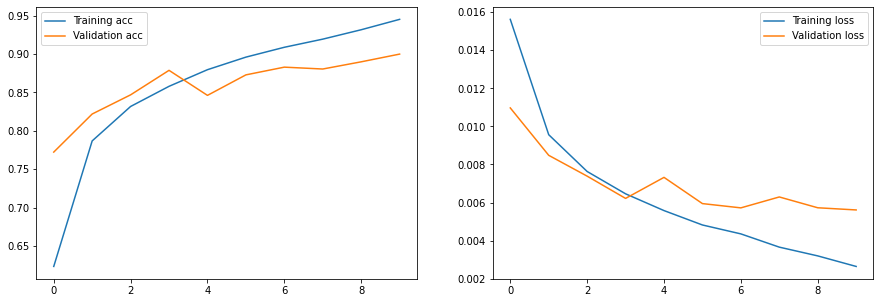

In [62]:
opt = torch.optim.SGD(net2.parameters(),lr=0.001,momentum=0.9)
hist = train(net2, train_loader,test_loader, epochs = 10, optimizer=opt, loss_fn=nn.CrossEntropyLoss())
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()


In [92]:
# Predicting on image from depop

img_set = torchvision.datasets.ImageFolder(root="D:\\misc\\Clothing\\final test",transform=T.Compose([T.Resize((64,64))
                                                                                                     ,T.ToTensor()
                                                                                                     ,T.Normalize(img_mean,img_std) ]))
img_load = torch.utils.data.DataLoader(img_set)

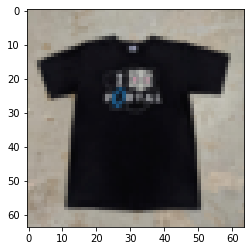

In [99]:
x = next(iter(img_load))[0]* torch.tensor(img_std)[:, None, None] + torch.tensor(img_mean)[:, None, None]
plt.imshow(x.squeeze().permute(1,2,0))

In [100]:
net2(next(iter(img_load))[0].cuda())

tensor([[-2.5878, -3.2386,  5.5284, -2.2138, -2.5912]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [101]:
#index at 2 (3rd option) has the highest
cat_dict[2]

'shirt'

# Above prediction was correct